In [1]:
import os
import sys

import librosa as lr
import librosa.display
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

In [2]:
DATASET_ROOT = "/home/saso/Documents/whale_data"
TRAINING_PATH = os.path.join(DATASET_ROOT, "train/")
RESOURCE_PATH = "./resources"
OUTPUT_PATH = "./output"
DF_WITH_CLUSTERS_PATH_LIMITED = os.path.join(OUTPUT_PATH, "df_with_clusters.csv")
FULL_DF_WITH_CLUSTERS_PATH = os.path.join(RESOURCE_PATH, "df_with_clusters_full.csv")
N_CLUSTERS = 3
SAMPLE_RATE = 2000
WHALE_LABEL = "Whale"
NOISE_LABEL = "Noise"

In [3]:
def compute_mfcc(limit=False):
    mfccs = []
    # Load dataset
    if limit:
        df = pd.read_csv(os.path.join(DATASET_ROOT, "train.csv"), nrows=1000)
    else:
        df = pd.read_csv(os.path.join(DATASET_ROOT, "train.csv"))
    for index, row in df.iterrows():
        full_track_name = TRAINING_PATH + row["clip_name"]
        audio, _ = lr.load(full_track_name, sr=SAMPLE_RATE, res_type='kaiser_fast')
        mfccs.append(np.mean(lr.feature.mfcc(y=audio, sr=SAMPLE_RATE), axis=1))
    return mfccs, df

In [4]:
mfccs, df = compute_mfcc(limit=True)  # limit the dataset load for testing purpouses
clustering_model = AgglomerativeClustering(n_clusters=N_CLUSTERS, metric='euclidean', linkage='ward')
clustering_model.fit(mfccs)
df['cluster'] = clustering_model.labels_
df.to_csv(DF_WITH_CLUSTERS_PATH_LIMITED, encoding='utf-8')
df = pd.read_csv(FULL_DF_WITH_CLUSTERS_PATH)

In [5]:
def show_cluster_hist_subplots(dataframe_with_clusters, number_of_clusters):
    fig, ax = plt.subplots(3, sharex=True, sharey=True)

    clusters = []
    for i in range(number_of_clusters):
        clusters.append(dataframe_with_clusters[dataframe_with_clusters["cluster"] == i])

    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.title("Histograms Whale/Noise for cluster")
    plt.xlabel("Target variable", labelpad=5)
    plt.ylabel("No. samples", labelpad=15)
    #
    for i in range(number_of_clusters):
        ax[i].hist(clusters[i]['label'])

    fig.tight_layout(pad=10.0)
    plt.show()

/tmp/ipykernel_10873/4101270450.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout(pad=10.0)


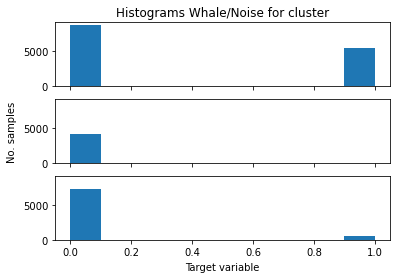

In [6]:
show_cluster_hist_subplots(df, N_CLUSTERS)

In [7]:
def map_target_var_to_label(dataframe_with_clusters):
    dict_mapping = {0: NOISE_LABEL, 1: WHALE_LABEL}
    dataframe_with_clusters['label'] = dataframe_with_clusters['label'].map(dict_mapping)

In [8]:
map_target_var_to_label(df)
df

,Unnamed: 0,clip_name,label,cluster
0,0,train1.aiff,Noise,2
1,1,train2.aiff,Noise,0
2,2,train3.aiff,Noise,0
3,3,train4.aiff,Noise,0
4,4,train5.aiff,Noise,0
...,...,...,...,...
29995,29995,train29996.aiff,Noise,0
29996,29996,train29997.aiff,Noise,0
29997,29997,train29998.aiff,Noise,0
29998,29998,train29999.aiff,Noise,3


In [9]:
def get_cluster_elements(dataframe_with_clusters, cluster_number):
    return dataframe_with_clusters[dataframe_with_clusters["cluster"] == cluster_number]

def groupby_cluster(dataframe_with_clusters):
    clusters = []
    for i in range(N_CLUSTERS):
        clusters.append(get_cluster_elements(dataframe_with_clusters, i))
    return clusters

def get_mfccs_and_mels(cluster):
    mfccs = []
    mels = []
    for index, row in cluster.iterrows():
        full_track_name = TRAINING_PATH + row["clip_name"]
        audio, _ = lr.load(full_track_name, sr=SAMPLE_RATE, res_type='kaiser_fast')
        mfccs.append(lr.feature.mfcc(y=audio, sr=SAMPLE_RATE))
        mels.append(lr.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=50))
    return mfccs, mels

In [10]:
clusters = groupby_cluster(df)
mfccs = []
mels = []
for i in range(3):
    mfcc, mel = get_mfccs_and_mels(clusters[i])
    mfccs.append(np.mean(mfcc, axis=0))
    mels.append(np.mean(mel, axis=0))

In [11]:
def show_cluster_mean_feature(mels, mfccs):
    fig, ax = plt.subplots(nrows=2, ncols=N_CLUSTERS, sharex=True)

    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.title("Melspectrogram and MFCC for clusters")
    plt.xlabel("Time", labelpad=5)
    plt.ylabel("Mel", labelpad=5)

    for i in range(N_CLUSTERS):
        lr.display.specshow(mels[i],
                            sr=SAMPLE_RATE, ax=ax[0, i])
    for i in range(N_CLUSTERS):
        lr.display.specshow(mfccs[i],
                            sr=SAMPLE_RATE, ax=ax[1, i])
    plt.show()

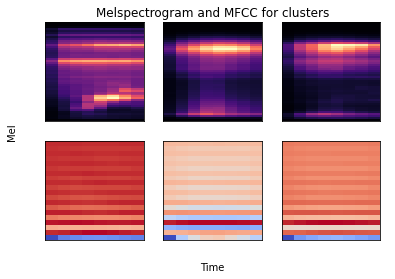

In [12]:
show_cluster_mean_feature(mels, mfccs)